<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:300%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="font-size:30px;text-align:center">Brain Tumor Detection🧠🎯</p>
</div>


<p style="text-align:center;"><img src="https://images.medicinenet.com/images/article/main_image/what-were-your-first-signs-of-a-brain-tumor.jpg" width="500" height="350">

A brain tumor is a mass or growth of abnormal cells in your brain.

Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain as secondary (metastatic) brain tumors.

How quickly a brain tumor grows can vary greatly. The growth rate as well as the location of a brain tumor determines how it will affect the function of your nervous system.

Brain tumor treatment options depend on the type of brain tumor you have, as well as its size and location.

<div style="color:Black;
           display:fill;
           border-radius:5px;
           background-color:#d4eefc;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px">
    
## CNN models:

* [VGG19](#1)
* [Inceptionv3](#2)  

# 1. Loads libraries

In [1]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

# 2. Loads Images

In [2]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

In [3]:
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/'

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


## 3. Image demonstration

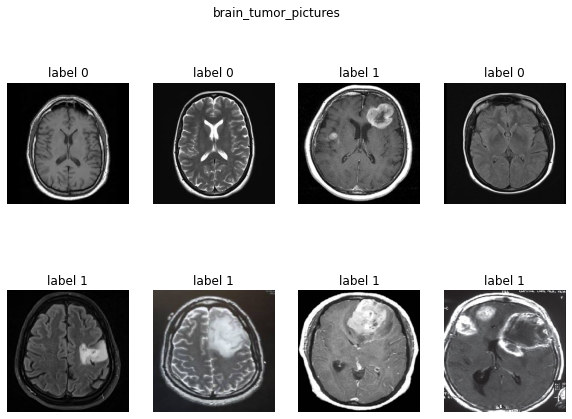

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

# 4. CNN Implementation

## 4.1 VGG19 Implementation
<a class="anchor" id="1"></a> 
The architecture of VGG19:


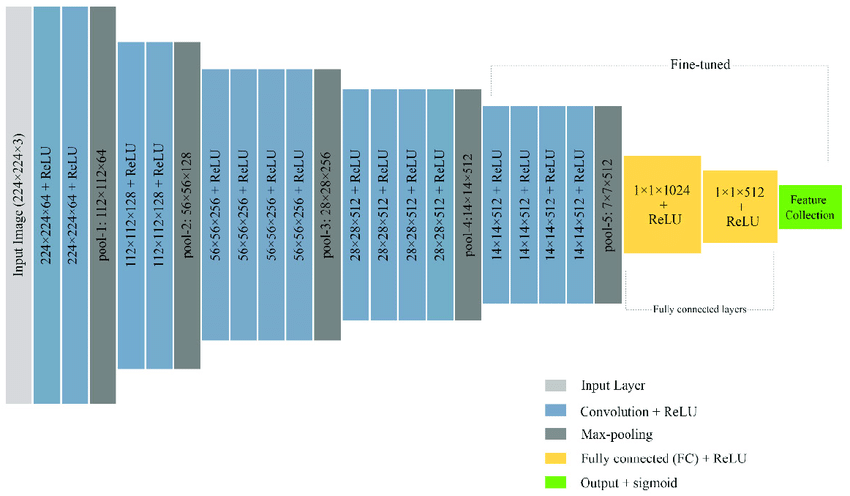!


The difference between VGG19 and VGG16 is just VGG19 get 3 more convolutional layers:


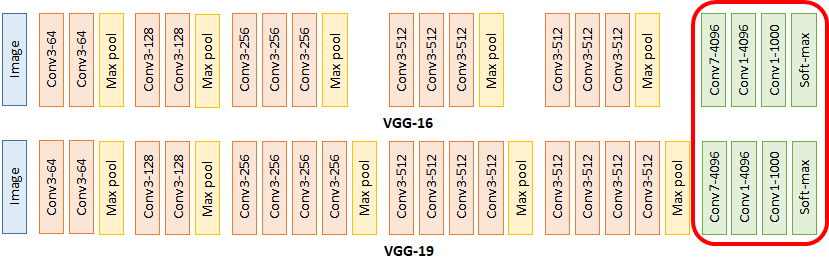!

In [5]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

2022-07-18 15:23:17.271039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 15:23:17.400859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 15:23:17.402121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 15:23:17.403835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [6]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

2022-07-18 15:23:23.087913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-07-18 15:23:25.644239: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4/4 [==============================] - 22s 2s/step - loss: 5.1234 - acc: 0.5567 - val_loss: 12.6026 - val_acc: 0.6200

Epoch 00001: acc improved from -inf to 0.55665, saving model to model/vgg19_best.h5
Epoch 2/25
4/4 [==============================] - 2s 510ms/step - loss: 10.1008 - acc: 0.6158 - val_loss: 2.4379 - val_acc: 0.7600

Epoch 00002: acc improved from 0.55665 to 0.61576, saving model to model/vgg19_best.h5
Epoch 3/25
4/4 [==============================] - 2s 497ms/step - loss: 3.9833 - acc: 0.6059 - val_loss: 3.2576 - val_acc: 0.7000

Epoch 00003: acc did not improve from 0.61576
Epoch 4/25
4/4 [==============================] - 2s 408ms/step - loss: 1.8352 - acc: 0.8079 - val_loss: 5.1510 - val_acc: 0.7800

Epoch 00004: acc improved from 0.61576 to 0.80788, saving model to model/vgg19_best.h5
Epoch 5/25
4/4 [==============================] - 2s 391ms/step - loss: 3.6408 - acc: 0.7833 - val_loss: 3.7714 - val_acc: 0.7600

Epoch 00005: acc did not improve from 0.80788
Epoch 

In [7]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 0s 365ms/step - loss: 1.3922 - acc: 0.8000


,Train,Val
Loss,0.110906,1.392248
Acc,0.945813,0.800000


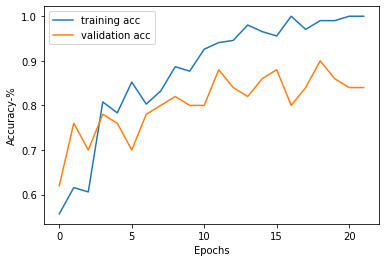

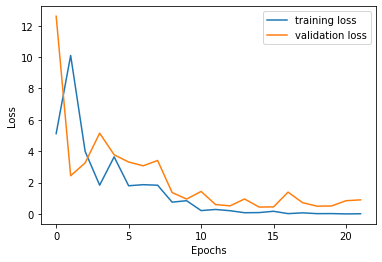

In [8]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

<h3>Adding Image Augmentation</h3>

In [9]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - 9s 931ms/step - loss: 0.8583 - acc: 0.8142 - val_loss: 0.7630 - val_acc: 0.8600

Epoch 00001: acc did not improve from 1.00000
Epoch 2/25
4/4 [==============================] - 4s 1s/step - loss: 0.7378 - acc: 0.8300 - val_loss: 0.3804 - val_acc: 0.8800

Epoch 00002: acc did not improve from 1.00000
Epoch 3/25
4/4 [==============================] - 5s 1s/step - loss: 0.9806 - acc: 0.8024 - val_loss: 0.7251 - val_acc: 0.8800

Epoch 00003: acc did not improve from 1.00000
Epoch 4/25
4/4 [==============================] - 4s 1s/step - loss: 0.7475 - acc: 0.8024 - val_loss: 0.3138 - val_acc: 0.9000

Epoch 00004: acc did not improve from 1.00000
Epoch 5/25
4/4 [==============================] - 5s 1s/step - loss: 0.4946 - acc: 0.8775 - val_loss: 0.3350 - val_acc: 0.9000

Epoch 00005: acc did not improve from 1.00000
Epoch 6/25
4/4 [==============================] - 5s 1s/step - loss: 0.3658 - acc: 0.8854 - val_loss: 0.1846 - val_acc: 0.9200


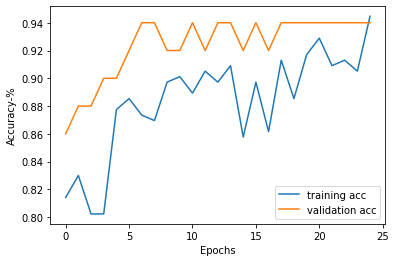

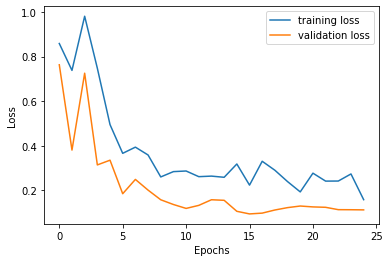

In [11]:
plot_learning_curve(history)

## Final VGG19 model results

In [12]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 0s 432ms/step - loss: 0.1122 - acc: 0.9400


,Train,Val
Loss,0.007403,0.11216
Acc,0.995074,0.94000


In [13]:
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

[[16  3]
 [ 0 31]]

               precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.91      0.95        34

    accuracy                           0.94        50
   macro avg       0.92      0.96      0.93        50
weighted avg       0.95      0.94      0.94        50



## 4.2 InceptionV3 Implementation
<a class="anchor" id="2"></a> 
The architecture of InceptionV3:


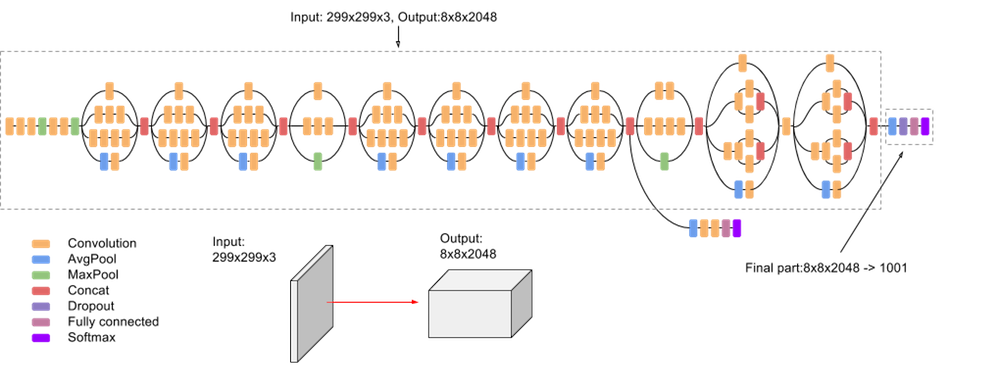!

In [14]:
# inception v3
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
87924736/87910968 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 131073    
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
# train inception v3
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - 10s 1s/step - loss: 6.9893 - acc: 0.4483 - val_loss: 10.0520 - val_acc: 0.6200

Epoch 00001: acc improved from -inf to 0.44828, saving model to model/inceptionv3_best.h5
Epoch 2/25
4/4 [==============================] - 2s 427ms/step - loss: 9.0855 - acc: 0.6158 - val_loss: 1.7414 - val_acc: 0.8600

Epoch 00002: acc improved from 0.44828 to 0.61576, saving model to model/inceptionv3_best.h5
Epoch 3/25
4/4 [==============================] - 2s 577ms/step - loss: 2.6705 - acc: 0.7734 - val_loss: 6.0907 - val_acc: 0.5800

Epoch 00003: acc improved from 0.61576 to 0.77340, saving model to model/inceptionv3_best.h5
Epoch 4/25
4/4 [==============================] - 2s 505ms/step - loss: 2.8305 - acc: 0.7488 - val_loss: 1.6757 - val_acc: 0.8800

Epoch 00004: acc did not improve from 0.77340
Epoch 5/25
4/4 [==============================] - 2s 556ms/step - loss: 1.3289 - acc: 0.8867 - val_loss: 2.5688 - val_acc: 0.9000

Epoch 00005: acc improve

In [16]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 0s 404ms/step - loss: 1.3033 - acc: 0.9000


,Train,Val
Loss,0.001668,1.303255
Acc,1.000000,0.900000


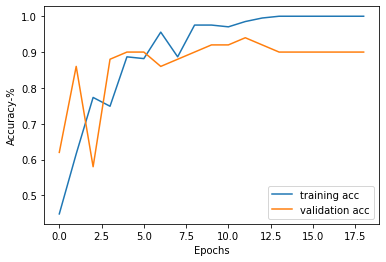

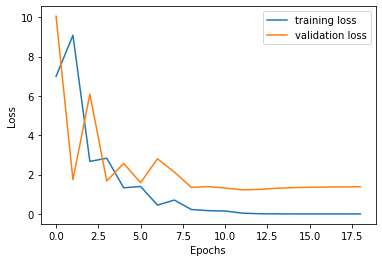

In [17]:
plot_learning_curve(history)

<h3>Adding Image augmentation...</h3>

In [18]:
aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/25
4/4 [==============================] - 8s 2s/step - loss: 1.6763 - acc: 0.8458 - val_loss: 4.2351 - val_acc: 0.6800

Epoch 00001: acc did not improve from 1.00000
Epoch 2/25
4/4 [==============================] - 7s 2s/step - loss: 2.2766 - acc: 0.7945 - val_loss: 1.9970 - val_acc: 0.8800

Epoch 00002: acc did not improve from 1.00000
Epoch 3/25
4/4 [==============================] - 7s 2s/step - loss: 1.2145 - acc: 0.8656 - val_loss: 0.7703 - val_acc: 0.9200

Epoch 00003: acc did not improve from 1.00000
Epoch 4/25
4/4 [==============================] - 8s 2s/step - loss: 0.8519 - acc: 0.8972 - val_loss: 1.6700 - val_acc: 0.8400

Epoch 00004: acc did not improve from 1.00000
Epoch 5/25
4/4 [==============================] - 7s 2s/step - loss: 1.0797 - acc: 0.8735 - val_loss: 0.9751 - val_acc: 0.8400

Epoch 00005: acc did not improve from 1.00000
Epoch 6/25
4/4 [==============================] - 7s 2s/step - loss: 0.6090 - acc: 0.9170

## Final InceptionV3 model results

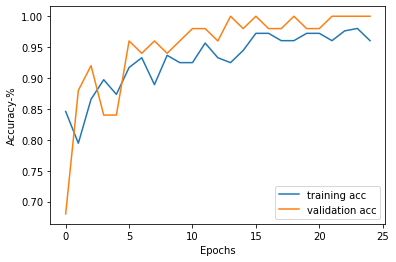

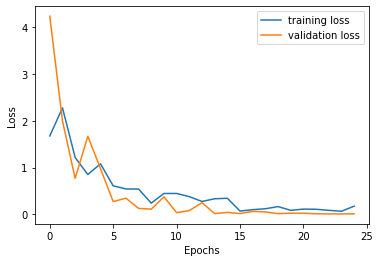

In [19]:
plot_learning_curve(history)

In [20]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 0s 402ms/step - loss: 0.0094 - acc: 1.0000


,Train,Val
Loss,0.000325,0.009436
Acc,1.000000,1.000000


In [21]:
ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

Confusion_Matrix:
 [[19  0]
 [ 0 31]]

Classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        31

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



## 5 Conclusion


Great! We have both CNN models achieve good accuracy results. 
The pretrained models used by Imagenet are always awesome!

After adding image augmentations, the model accuracy improved a lot.

Please upvote if you like it!
Thank you!
